# Using RNNs to predict time series


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

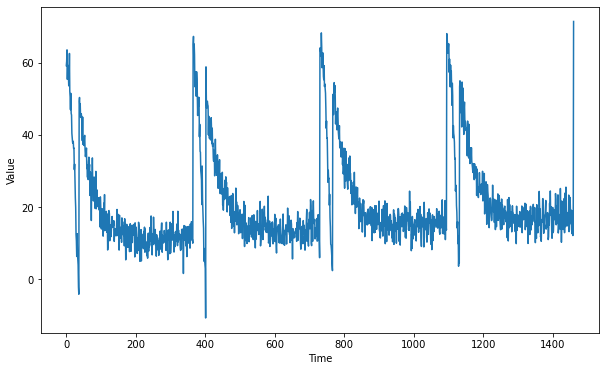

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [4]:
# Split the dataset
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
# Apply the transformation to the training set
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

dataset = windowed_dataset(series_train)

In [6]:
def create_uncompiled_model():

    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences = True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*100.0)
    ]) 

    return model

In [7]:
uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


In [8]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(momentum = 0.8)

    huber = tf.keras.losses.Huber()
    model.compile(loss=huber,
                  optimizer=optimizer, 
                  metrics=["mae"]) 

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [9]:

lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 7s 17ms/step - loss: 13.7924 - mae: 14.2806
Epoch 2/100
34/34 [==============================] - 1s 17ms/step - loss: 5.3976 - mae: 5.8712
Epoch 3/100
34/34 [==============================] - 1s 17ms/step - loss: 4.7213 - mae: 5.1882
Epoch 4/100
34/34 [==============================] - 1s 17ms/step - loss: 4.4733 - mae: 4.9401
Epoch 5/100
34/34 [==============================] - 1s 17ms/step - loss: 4.4023 - mae: 4.8691
Epoch 6/100
34/34 [==============================] - 1s 16ms/step - loss: 4.2497 - mae: 4.7168
Epoch 7/100
34/34 [==============================] - 1s 19ms/step - loss: 4.1742 - mae: 4.6453
Epoch 8/100
34/34 [==============================] - 1s 18ms/step - loss: 4.0353 - mae: 4.5093
Epoch 9/100
34/34 [==============================] - 1s 16ms/step - loss: 3.9632 - mae: 4.4342
Epoch 10/100
34/34 [==============================] - 1s 18ms/step - loss: 3.9457 - mae: 4.4152
Epoch 11/100
34/34 [===========================

34/34 [==============================] - 1s 17ms/step - loss: 97.2169 - mae: 97.7169
Epoch 87/100
34/34 [==============================] - 1s 18ms/step - loss: 108.6137 - mae: 109.1137
Epoch 88/100
34/34 [==============================] - 1s 18ms/step - loss: 122.1413 - mae: 122.6413
Epoch 89/100
34/34 [==============================] - 1s 18ms/step - loss: 137.5522 - mae: 138.0522
Epoch 90/100
34/34 [==============================] - 1s 18ms/step - loss: 153.5382 - mae: 154.0382
Epoch 91/100
34/34 [==============================] - 1s 19ms/step - loss: 172.9195 - mae: 173.4195
Epoch 92/100
34/34 [==============================] - 1s 19ms/step - loss: 193.6701 - mae: 194.1701
Epoch 93/100
34/34 [==============================] - 1s 19ms/step - loss: 217.8801 - mae: 218.3801
Epoch 94/100
34/34 [==============================] - 1s 18ms/step - loss: 244.2989 - mae: 244.7989
Epoch 95/100
34/34 [==============================] - 1s 17ms/step - loss: 274.4150 - mae: 274.9150
Epoch 96/100
34

(1e-06, 1.0, 0.0, 30.0)

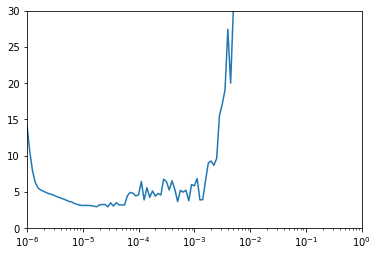

In [14]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

In [20]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()
    
    huber = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.SGD(learning_rate = 3e-5, momentum = 0.8)
    model.compile(loss=huber,
                  optimizer=optimizer,
                  metrics=["mae"])  

    return model

In [21]:
model = create_model()
history = model.fit(dataset, epochs=40)

Epoch 1/40
34/34 [==============================] - 8s 72ms/step - loss: 5.4697 - mae: 5.9509
Epoch 2/40
34/34 [==============================] - 2s 58ms/step - loss: 3.8927 - mae: 4.3617
Epoch 3/40
34/34 [==============================] - 2s 55ms/step - loss: 4.0127 - mae: 4.4819
Epoch 4/40
34/34 [==============================] - 2s 52ms/step - loss: 4.0716 - mae: 4.5470
Epoch 5/40
34/34 [==============================] - 2s 53ms/step - loss: 3.4669 - mae: 3.9344
Epoch 6/40
34/34 [==============================] - 2s 54ms/step - loss: 3.2166 - mae: 3.6825
Epoch 7/40
34/34 [==============================] - 2s 52ms/step - loss: 3.5147 - mae: 3.9866
Epoch 8/40
34/34 [==============================] - 2s 52ms/step - loss: 3.1648 - mae: 3.6310
Epoch 9/40
34/34 [==============================] - 2s 54ms/step - loss: 3.9918 - mae: 4.4676
Epoch 10/40
34/34 [==============================] - 2s 54ms/step - loss: 3.0067 - mae: 3.4693
Epoch 11/40
34/34 [==============================] - 2s 54m

In [22]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [23]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

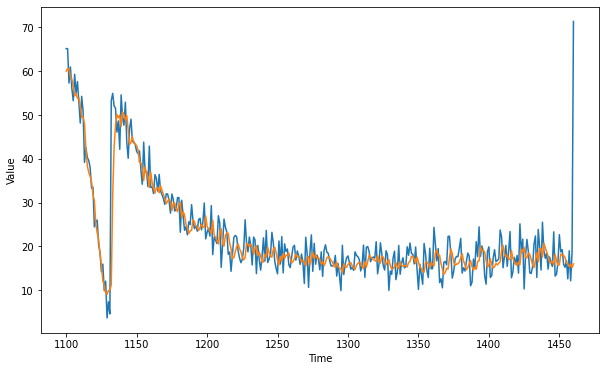

In [24]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [25]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 27.57, mae: 3.15 for forecast


In [26]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/
